# Classification Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification task (`Low`, `Medium`, `High`).  It now includes additional metrics in hyperparameter tuning and enhanced model comparison visualizations.

## Table of Contents
1. [Environment & Setup](#step1)
2. [Model Definition](#step2)
3. [Evaluation Function](#step3)
4. [Hyperparameter Sweep (10-Fold CV)](#step4)
5. [Retraining & Validation (10-Fold CV)](#step5)
6. [Cross-Validation Results Visualization](#step6)
7. [Ensemble Averaging](#step7)
8. [Final Model Training & Test Evaluation](#step8)
9. [Baseline QSAR Comparison](#step9)

---

## Prerequisites
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (only for feature extraction)  
- GPU recommended

Install requirements:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

<a id="step1"></a>
## Step 1: Environment & Setup
- Seed all random generators for reproducibility.  
- Define paths for data splits and output.  
- Detect GPU/CPU.

<a id="step2"></a>
## Step 2: Model Definition
Defines:
- `MPNNLayer`: message-passing with dropout support.  
- `MPNN`: stacks layers, global mean pool, and final linear head.

<a id="step3"></a>
## Step 3: Evaluation Function
`evaluate(model, loader)` returns concatenated logits and true labels.

<a id="step4"></a>
## Step 4: Hyperparameter Sweep (10-Fold CV)
**Updates:** Now tracks both **AUC-ROC** and **Balanced Accuracy** per fold.

- Grid search over `hidden_dim`, `dropout`, `lr`.  
- For each config, run 10-fold CV: train for 50 epochs, then evaluate validation set.
- Compute per-fold metrics:
  - **AUC-ROC** (one-vs-rest)
  - **Balanced Accuracy** (accounts for class imbalance)
- Record **mean ± std** for both metrics.
- Results DataFrame `sweep_df` now contains `mean_auc`, `std_auc`, `mean_balanced_acc`, and `std_balanced_acc`.

<a id="step5"></a>
## Step 5: Retraining & Validation (10-Fold CV)
- Retrain each fold with best hyperparameters and early stopping.  
- Save best model weights.  
- Compute per-fold classification metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv`.

<a id="step6"></a>
## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± std.

<a id="step7"></a>
## Step 7: Ensemble Averaging
- Load fold checkpoints, run on test set, average logits.  
- Save `ensemble_preds.csv` (True vs. Pred).
- **Ensemble evaluation plots** include confusion matrix and per-class ROC curves.

<a id="step8"></a>
## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds, reserve 10% for validation.  
- Train final model with early stopping and LR scheduler.  
- Evaluate on hold-out test: accuracy, precision, recall, F1, AUC-ROC.
- Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv`, `final_confusion_matrix.png`, and `final_auc_roc.png`.


---

## Parameters & Extensions
- **Epochs:** 50 for CV, 100 for final training  
- **Patience:** 10 for early stopping  
- **LR Scheduler:** `ReduceLROnPlateau` on validation loss  





## 1. Imports and Setup

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [2]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

task = "classification"  # or "regression"
#task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"MPNN_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3b. Define MPNN Layer and MPNN Model with Dropout Support
# Enhanced MPNN model with dropout layers after each message-passing block to reduce overfitting.

In [3]:
class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels)
        self.edge_proj = Linear(edge_dim, out_channels)
        self.msg_lin = Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.lin(x)
        edge_attr = self.edge_proj(edge_attr)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return self.msg_lin(x_j + edge_attr)

    def update(self, aggr_out):
        return F.relu(aggr_out)

class MPNN(torch.nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, output_dim, dropout=0.0):
        super().__init__()
        self.dropout = dropout
        self.mp1 = MPNNLayer(input_dim, hidden_dim, edge_dim)
        self.mp2 = MPNNLayer(hidden_dim, hidden_dim, edge_dim)
        self.out = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.mp1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.mp2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, data.batch)
        return self.out(x)


## 4. Evaluation Helper Function

In [4]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [5]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ## Step 4: Hyperparameter tuning

In [86]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

hidden_dims = [64, 128, 256]
dropouts    = [0.0, 0.2, 0.4]
lrs         = [1e-3, 5e-4, 1e-4]

results = []

for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            print(f"\n🔧 Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            auc_scores = []
            bal_scores = []

            for fold in range(10):
                print(f"\n▶️ Fold {fold+1}/10")
                # 1) Load data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
                tr_loader  = DataLoader(train_data, batch_size=32, shuffle=True,
                                        worker_init_fn=seed_worker, generator=generator)
                vl_loader  = DataLoader(val_data,   batch_size=32)

                # 2) Init model & optimizer
                model = MPNN(
                    train_data[0].x.size(1),
                    train_data[0].edge_attr.size(1),
                    hidden_dim=hd,
                    output_dim=num_classes,
                    dropout=dp
                ).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # 3) Train + validate each epoch
                for epoch in range(1, 51):
                    # --- train ---
                    model.train()
                    total_train_loss = 0.0
                    for batch in tr_loader:
                        batch = batch.to(device)
                        optimizer.zero_grad()
                        out = model(batch)
                        loss = F.cross_entropy(out, batch.y.long())
                        loss.backward()
                        optimizer.step()
                        total_train_loss += loss.item()
                    avg_train_loss = total_train_loss / len(tr_loader)

                    # --- validate ---
                    model.eval()
                    preds_val, labels_val = evaluate(model, vl_loader)
                    val_loss = F.cross_entropy(preds_val, labels_val.long()).item()

                    # Print per‑epoch
                    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

                # 4) After 50 epochs, compute fold‐level metrics
                y_true  = labels_val.numpy().astype(int)
                y_probs = F.softmax(preds_val, dim=1).cpu().numpy()
                y_pred  = preds_val.argmax(dim=1).cpu().numpy()

                # AUC‑ROC
                auc = roc_auc_score(
                    label_binarize(y_true, classes=np.arange(num_classes)),
                    y_probs,
                    multi_class='ovr'
                )
                auc_scores.append(auc)

                # Balanced Accuracy
                bal = balanced_accuracy_score(y_true, y_pred)
                bal_scores.append(bal)

                print(f"Fold {fold+1} ▶ AUC: {auc:.3f}, Balanced Acc: {bal:.3f}")

            # 5) Record mean±std for both metrics
            results.append({
                "hidden_dim":        hd,
                "dropout":           dp,
                "lr":                lr,
                "mean_auc":          np.mean(auc_scores),
                "std_auc":           np.std(auc_scores),
                "mean_balanced_acc": np.mean(bal_scores),
                "std_balanced_acc":  np.std(bal_scores),
            })

            print(
                f"🔍 Summary for hd={hd}, dp={dp}, lr={lr} → "
                f"AUC: {np.mean(auc_scores):.4f}±{np.std(auc_scores):.4f} | "
                f"BalAcc: {np.mean(bal_scores):.4f}±{np.std(bal_scores):.4f}"
            )

# 6) Build & save the sweep DataFrame
sweep_df = pd.DataFrame(results)
display(sweep_df.sort_values("mean_balanced_acc", ascending=False))
sweep_df.to_csv(os.path.join(results_dir, "sweep_results.csv"), index=False)



🔧 Config: hidden_dim=64, dropout=0.0, lr=0.001

▶️ Fold 1/10
Epoch 01 | Train Loss: 0.8949 | Val Loss: 0.8664
Epoch 02 | Train Loss: 0.8785 | Val Loss: 0.8628
Epoch 03 | Train Loss: 0.8721 | Val Loss: 0.8559
Epoch 04 | Train Loss: 0.8679 | Val Loss: 0.8545
Epoch 05 | Train Loss: 0.8593 | Val Loss: 0.8383
Epoch 06 | Train Loss: 0.8413 | Val Loss: 0.8149
Epoch 07 | Train Loss: 0.8040 | Val Loss: 0.7891
Epoch 08 | Train Loss: 0.7854 | Val Loss: 0.7565
Epoch 09 | Train Loss: 0.7875 | Val Loss: 0.7233
Epoch 10 | Train Loss: 0.7507 | Val Loss: 0.7179
Epoch 11 | Train Loss: 0.7515 | Val Loss: 0.7210
Epoch 12 | Train Loss: 0.7560 | Val Loss: 0.7173
Epoch 13 | Train Loss: 0.7325 | Val Loss: 0.6958
Epoch 14 | Train Loss: 0.7480 | Val Loss: 0.7214
Epoch 15 | Train Loss: 0.7384 | Val Loss: 0.7050
Epoch 16 | Train Loss: 0.7649 | Val Loss: 0.7033
Epoch 17 | Train Loss: 0.7493 | Val Loss: 0.6951
Epoch 18 | Train Loss: 0.7574 | Val Loss: 0.6871
Epoch 19 | Train Loss: 0.7423 | Val Loss: 0.6947
Epoch 2

,hidden_dim,dropout,lr,mean_auc,std_auc,mean_balanced_acc,std_balanced_acc
0,64,0.0,0.0010,0.740911,0.040183,0.495892,0.031040
19,256,0.0,0.0005,0.741266,0.029381,0.494863,0.061726
26,256,0.4,0.0001,0.736698,0.041194,0.492965,0.041652
7,64,0.4,0.0005,0.734273,0.031274,0.489354,0.037088
13,128,0.2,0.0005,0.735719,0.032935,0.488238,0.034522
6,64,0.4,0.0010,0.744519,0.030233,0.487379,0.042169
1,64,0.0,0.0005,0.747255,0.032457,0.486776,0.039727
18,256,0.0,0.0010,0.741190,0.027803,0.483712,0.028075
22,256,0.2,0.0005,0.743077,0.037701,0.483521,0.048390
20,256,0.0,0.0001,0.742395,0.039246,0.483151,0.045603


# Use this section to manually define the best hyperparameters based on the sweep above.


In [16]:

# Load the best model configuration
#best_config = sweep_df.loc[sweep_df["mean_balanced_acc"].idxmax()]
best_hidden_dim = 64 #best_config["hidden_dim"]
best_dropout = 0.0 #best_config["dropout"]
best_lr = 0.001 #best_config["lr"]
print(f"Best config: hidden_dim={best_hidden_dim}, dropout={best_dropout}, lr={best_lr}")

Best config: hidden_dim=64, dropout=0.0, lr=0.001


# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [19]:
# %%
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd
fold_metrics = []


for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = MPNN(train_data[0].x.size(1),
                 train_data[0].edge_attr.size(1),
                 hidden_dim=best_hidden_dim,
                 output_dim=num_classes,
                 dropout=best_dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=best_lr)
    tr = DataLoader(train_data, batch_size=32, shuffle=True,
                    worker_init_fn=seed_worker, generator=generator)
    vl = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf'); patience=0
    for epoch in range(1, 101):
        model.train(); total=0
        for batch in tr:
            batch=batch.to(device); opt.zero_grad(); out=model(batch)
            loss=F.cross_entropy(out,batch.y.long()); loss.backward(); opt.step(); total+=loss.item()
        preds, labels = evaluate(model, vl)
        y_true = labels.numpy().astype(int)
        y_probs = F.softmax(preds, dim=1).numpy()
        val_loss = F.cross_entropy(preds, labels.long()).item()
        print(f"Epoch {epoch:03d} | Train Loss: {total / len(tr):.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss<best_val_loss:
            best_val_loss=val_loss; patience=0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience+=1
            if patience>=10: break
    print(f"Best val loss: {best_val_loss:.4f} | Early stopping patience: {patience}")
    

    # Metrics
    y_pred = preds.argmax(dim=1).numpy()
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), y_probs, multi_class='ovr')
    fold_metrics.append({"fold":fold+1,"accuracy":acc,"precision":precision,"recall":recall,"f1_score":f1,"auc_roc":auc})

# Save CV summary
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print("✅ Saved CV summary")



🔁 Retraining Fold 1/10
Epoch 001 | Train Loss: 0.9326 | Val Loss: 0.8690
Epoch 002 | Train Loss: 0.8846 | Val Loss: 0.8552
Epoch 003 | Train Loss: 0.8665 | Val Loss: 0.8470
Epoch 004 | Train Loss: 0.8461 | Val Loss: 0.8456
Epoch 005 | Train Loss: 0.8591 | Val Loss: 0.8276
Epoch 006 | Train Loss: 0.8340 | Val Loss: 0.8260
Epoch 007 | Train Loss: 0.8396 | Val Loss: 0.8117
Epoch 008 | Train Loss: 0.8163 | Val Loss: 0.8564
Epoch 009 | Train Loss: 0.8267 | Val Loss: 0.7733
Epoch 010 | Train Loss: 0.7883 | Val Loss: 0.7571
Epoch 011 | Train Loss: 0.7798 | Val Loss: 0.7439
Epoch 012 | Train Loss: 0.7752 | Val Loss: 0.7406
Epoch 013 | Train Loss: 0.7660 | Val Loss: 0.7453
Epoch 014 | Train Loss: 0.7475 | Val Loss: 0.7875
Epoch 015 | Train Loss: 0.7779 | Val Loss: 0.7261
Epoch 016 | Train Loss: 0.7534 | Val Loss: 0.7273
Epoch 017 | Train Loss: 0.7428 | Val Loss: 0.7179
Epoch 018 | Train Loss: 0.7507 | Val Loss: 0.7384
Epoch 019 | Train Loss: 0.7478 | Val Loss: 0.7189
Epoch 020 | Train Loss: 0.

/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9149 | Val Loss: 0.8663
Epoch 002 | Train Loss: 0.8858 | Val Loss: 0.8658
Epoch 003 | Train Loss: 0.8741 | Val Loss: 0.8587
Epoch 004 | Train Loss: 0.8569 | Val Loss: 0.8720
Epoch 005 | Train Loss: 0.8742 | Val Loss: 0.8525
Epoch 006 | Train Loss: 0.8757 | Val Loss: 0.8368
Epoch 007 | Train Loss: 0.8515 | Val Loss: 0.8492
Epoch 008 | Train Loss: 0.8418 | Val Loss: 0.8535
Epoch 009 | Train Loss: 0.8428 | Val Loss: 0.7936
Epoch 010 | Train Loss: 0.8474 | Val Loss: 0.7919
Epoch 011 | Train Loss: 0.8167 | Val Loss: 0.7722
Epoch 012 | Train Loss: 0.8058 | Val Loss: 0.7391
Epoch 013 | Train Loss: 0.8154 | Val Loss: 0.7498
Epoch 014 | Train Loss: 0.8093 | Val Loss: 0.8016
Epoch 015 | Train Loss: 0.7640 | Val Loss: 0.7482
Epoch 016 | Train Loss: 0.7418 | Val Loss: 0.7299
Epoch 017 | Train Loss: 0.7392 | Val Loss: 0.7027
Epoch 018 | Train Loss: 0.7598 | Val Loss: 0.7088
Epoch 019 | Train Loss: 0.7459 | Val Loss: 0.6986
Epoch 020 | Train Loss: 0.7570 | Val Loss: 0.7256


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9320 | Val Loss: 0.8718
Epoch 002 | Train Loss: 0.9034 | Val Loss: 0.8749
Epoch 003 | Train Loss: 0.8725 | Val Loss: 0.8479
Epoch 004 | Train Loss: 0.8751 | Val Loss: 0.8512
Epoch 005 | Train Loss: 0.8527 | Val Loss: 0.8396
Epoch 006 | Train Loss: 0.8482 | Val Loss: 0.8294
Epoch 007 | Train Loss: 0.8681 | Val Loss: 0.8233
Epoch 008 | Train Loss: 0.8432 | Val Loss: 0.8106
Epoch 009 | Train Loss: 0.8231 | Val Loss: 0.7870
Epoch 010 | Train Loss: 0.7943 | Val Loss: 0.7732
Epoch 011 | Train Loss: 0.7969 | Val Loss: 0.7792
Epoch 012 | Train Loss: 0.7862 | Val Loss: 0.7559
Epoch 013 | Train Loss: 0.7909 | Val Loss: 0.7723
Epoch 014 | Train Loss: 0.7485 | Val Loss: 0.7592
Epoch 015 | Train Loss: 0.7814 | Val Loss: 0.7489
Epoch 016 | Train Loss: 0.7686 | Val Loss: 0.7489
Epoch 017 | Train Loss: 0.7852 | Val Loss: 0.8365
Epoch 018 | Train Loss: 0.7470 | Val Loss: 0.7407
Epoch 019 | Train Loss: 0.7504 | Val Loss: 0.7380
Epoch 020 | Train Loss: 0.7691 | Val Loss: 0.7497


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 002 | Train Loss: 0.8874 | Val Loss: 0.8571
Epoch 003 | Train Loss: 0.8666 | Val Loss: 0.8521
Epoch 004 | Train Loss: 0.8676 | Val Loss: 0.8418
Epoch 005 | Train Loss: 0.8756 | Val Loss: 0.8399
Epoch 006 | Train Loss: 0.8661 | Val Loss: 0.8392
Epoch 007 | Train Loss: 0.8483 | Val Loss: 0.8272
Epoch 008 | Train Loss: 0.8347 | Val Loss: 0.8050
Epoch 009 | Train Loss: 0.8243 | Val Loss: 0.7909
Epoch 010 | Train Loss: 0.8192 | Val Loss: 0.7684
Epoch 011 | Train Loss: 0.7974 | Val Loss: 0.7515
Epoch 012 | Train Loss: 0.8106 | Val Loss: 0.7289
Epoch 013 | Train Loss: 0.8006 | Val Loss: 0.7347
Epoch 014 | Train Loss: 0.7729 | Val Loss: 0.7186
Epoch 015 | Train Loss: 0.7642 | Val Loss: 0.7069
Epoch 016 | Train Loss: 0.7677 | Val Loss: 0.7624
Epoch 017 | Train Loss: 0.7577 | Val Loss: 0.7081
Epoch 018 | Train Loss: 0.7455 | Val Loss: 0.6853
Epoch 019 | Train Loss: 0.7509 | Val Loss: 0.7073
Epoch 020 | Train Loss: 0.7519 | Val Loss: 0.6771
Epoch 021 | Train Loss: 0.7447 | Val Loss: 0.6968


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9310 | Val Loss: 0.8985
Epoch 002 | Train Loss: 0.8771 | Val Loss: 0.8919
Epoch 003 | Train Loss: 0.8614 | Val Loss: 0.8819
Epoch 004 | Train Loss: 0.8419 | Val Loss: 0.8801
Epoch 005 | Train Loss: 0.8494 | Val Loss: 0.8779
Epoch 006 | Train Loss: 0.8202 | Val Loss: 0.8453
Epoch 007 | Train Loss: 0.8208 | Val Loss: 0.9116
Epoch 008 | Train Loss: 0.8153 | Val Loss: 0.8272
Epoch 009 | Train Loss: 0.7861 | Val Loss: 0.8318
Epoch 010 | Train Loss: 0.7612 | Val Loss: 0.8179
Epoch 011 | Train Loss: 0.7573 | Val Loss: 0.8201
Epoch 012 | Train Loss: 0.7749 | Val Loss: 0.8533
Epoch 013 | Train Loss: 0.7692 | Val Loss: 0.8325
Epoch 014 | Train Loss: 0.7658 | Val Loss: 0.8626
Epoch 015 | Train Loss: 0.7643 | Val Loss: 0.8386
Epoch 016 | Train Loss: 0.7483 | Val Loss: 0.8257
Epoch 017 | Train Loss: 0.7240 | Val Loss: 0.8324
Epoch 018 | Train Loss: 0.7327 | Val Loss: 0.8230
Epoch 019 | Train Loss: 0.7483 | Val Loss: 0.8199
Epoch 020 | Train Loss: 0.7277 | Val Loss: 0.8191


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9120 | Val Loss: 0.9271
Epoch 002 | Train Loss: 0.8893 | Val Loss: 0.8921
Epoch 003 | Train Loss: 0.8746 | Val Loss: 0.8851
Epoch 004 | Train Loss: 0.8512 | Val Loss: 0.8775
Epoch 005 | Train Loss: 0.8407 | Val Loss: 0.9041
Epoch 006 | Train Loss: 0.8544 | Val Loss: 0.9065
Epoch 007 | Train Loss: 0.8447 | Val Loss: 0.8675
Epoch 008 | Train Loss: 0.8374 | Val Loss: 0.8576
Epoch 009 | Train Loss: 0.7935 | Val Loss: 0.8694
Epoch 010 | Train Loss: 0.8213 | Val Loss: 0.8395
Epoch 011 | Train Loss: 0.7793 | Val Loss: 0.8281
Epoch 012 | Train Loss: 0.7650 | Val Loss: 0.8465
Epoch 013 | Train Loss: 0.7742 | Val Loss: 0.8328
Epoch 014 | Train Loss: 0.7564 | Val Loss: 0.8366
Epoch 015 | Train Loss: 0.7585 | Val Loss: 0.8407
Epoch 016 | Train Loss: 0.7527 | Val Loss: 0.8351
Epoch 017 | Train Loss: 0.7391 | Val Loss: 0.8230
Epoch 018 | Train Loss: 0.7213 | Val Loss: 0.8275
Epoch 019 | Train Loss: 0.7394 | Val Loss: 0.8285
Epoch 020 | Train Loss: 0.7262 | Val Loss: 0.8166


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9311 | Val Loss: 0.8828
Epoch 002 | Train Loss: 0.8768 | Val Loss: 0.8592
Epoch 003 | Train Loss: 0.8625 | Val Loss: 0.8523
Epoch 004 | Train Loss: 0.8750 | Val Loss: 0.8615
Epoch 005 | Train Loss: 0.8643 | Val Loss: 0.8376
Epoch 006 | Train Loss: 0.8602 | Val Loss: 0.8434
Epoch 007 | Train Loss: 0.8445 | Val Loss: 0.8230
Epoch 008 | Train Loss: 0.8278 | Val Loss: 0.8046
Epoch 009 | Train Loss: 0.8183 | Val Loss: 0.7770
Epoch 010 | Train Loss: 0.8031 | Val Loss: 0.7830
Epoch 011 | Train Loss: 0.8056 | Val Loss: 0.7477
Epoch 012 | Train Loss: 0.7790 | Val Loss: 0.7362
Epoch 013 | Train Loss: 0.7930 | Val Loss: 0.7819
Epoch 014 | Train Loss: 0.8056 | Val Loss: 0.8089
Epoch 015 | Train Loss: 0.7693 | Val Loss: 0.7408
Epoch 016 | Train Loss: 0.7436 | Val Loss: 0.7189
Epoch 017 | Train Loss: 0.7298 | Val Loss: 0.7289
Epoch 018 | Train Loss: 0.7454 | Val Loss: 0.7240
Epoch 019 | Train Loss: 0.7321 | Val Loss: 0.7188
Epoch 020 | Train Loss: 0.7187 | Val Loss: 0.7694


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9091 | Val Loss: 0.8759
Epoch 002 | Train Loss: 0.8717 | Val Loss: 0.8547
Epoch 003 | Train Loss: 0.8632 | Val Loss: 0.8390
Epoch 004 | Train Loss: 0.8482 | Val Loss: 0.8368
Epoch 005 | Train Loss: 0.8436 | Val Loss: 0.8364
Epoch 006 | Train Loss: 0.8310 | Val Loss: 0.8079
Epoch 007 | Train Loss: 0.8053 | Val Loss: 0.8178
Epoch 008 | Train Loss: 0.7961 | Val Loss: 0.8070
Epoch 009 | Train Loss: 0.7794 | Val Loss: 0.7854
Epoch 010 | Train Loss: 0.7704 | Val Loss: 0.8031
Epoch 011 | Train Loss: 0.7721 | Val Loss: 0.7976
Epoch 012 | Train Loss: 0.7966 | Val Loss: 0.7931
Epoch 013 | Train Loss: 0.7591 | Val Loss: 0.7922
Epoch 014 | Train Loss: 0.7560 | Val Loss: 0.8379
Epoch 015 | Train Loss: 0.7873 | Val Loss: 0.7942
Epoch 016 | Train Loss: 0.7450 | Val Loss: 0.8021
Epoch 017 | Train Loss: 0.7431 | Val Loss: 0.8007
Epoch 018 | Train Loss: 0.7674 | Val Loss: 0.7947
Epoch 019 | Train Loss: 0.7313 | Val Loss: 0.7990
Best val loss: 0.7854 | Early stopping patience: 1

/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9530 | Val Loss: 0.8849
Epoch 002 | Train Loss: 0.8849 | Val Loss: 0.8691
Epoch 003 | Train Loss: 0.8752 | Val Loss: 0.8650
Epoch 004 | Train Loss: 0.8697 | Val Loss: 0.8601
Epoch 005 | Train Loss: 0.8573 | Val Loss: 0.8639
Epoch 006 | Train Loss: 0.8674 | Val Loss: 0.8497
Epoch 007 | Train Loss: 0.8352 | Val Loss: 0.8452
Epoch 008 | Train Loss: 0.8255 | Val Loss: 0.8347
Epoch 009 | Train Loss: 0.8088 | Val Loss: 0.8216
Epoch 010 | Train Loss: 0.7752 | Val Loss: 0.8146
Epoch 011 | Train Loss: 0.7767 | Val Loss: 0.8277
Epoch 012 | Train Loss: 0.7592 | Val Loss: 0.7947
Epoch 013 | Train Loss: 0.7472 | Val Loss: 0.8112
Epoch 014 | Train Loss: 0.7468 | Val Loss: 0.7997
Epoch 015 | Train Loss: 0.7347 | Val Loss: 0.7879
Epoch 016 | Train Loss: 0.7563 | Val Loss: 0.8046
Epoch 017 | Train Loss: 0.7582 | Val Loss: 0.7961
Epoch 018 | Train Loss: 0.7415 | Val Loss: 0.7670
Epoch 019 | Train Loss: 0.7419 | Val Loss: 0.7700
Epoch 020 | Train Loss: 0.7691 | Val Loss: 0.7608


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9285 | Val Loss: 0.8751
Epoch 002 | Train Loss: 0.8729 | Val Loss: 0.8675
Epoch 003 | Train Loss: 0.8745 | Val Loss: 0.8636
Epoch 004 | Train Loss: 0.8546 | Val Loss: 0.8741
Epoch 005 | Train Loss: 0.8659 | Val Loss: 0.8552
Epoch 006 | Train Loss: 0.8474 | Val Loss: 0.8928
Epoch 007 | Train Loss: 0.8433 | Val Loss: 0.8470
Epoch 008 | Train Loss: 0.8325 | Val Loss: 0.8293
Epoch 009 | Train Loss: 0.8260 | Val Loss: 0.8102
Epoch 010 | Train Loss: 0.7864 | Val Loss: 0.7870
Epoch 011 | Train Loss: 0.7988 | Val Loss: 0.7759
Epoch 012 | Train Loss: 0.7537 | Val Loss: 0.7729
Epoch 013 | Train Loss: 0.7580 | Val Loss: 0.7637
Epoch 014 | Train Loss: 0.7394 | Val Loss: 0.7557
Epoch 015 | Train Loss: 0.7427 | Val Loss: 0.7569
Epoch 016 | Train Loss: 0.7357 | Val Loss: 0.7882
Epoch 017 | Train Loss: 0.7207 | Val Loss: 0.7921
Epoch 018 | Train Loss: 0.7435 | Val Loss: 0.8039
Epoch 019 | Train Loss: 0.7235 | Val Loss: 0.7612
Epoch 020 | Train Loss: 0.7122 | Val Loss: 0.7654


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ## Step 6: Visualize Cross-Validation Results


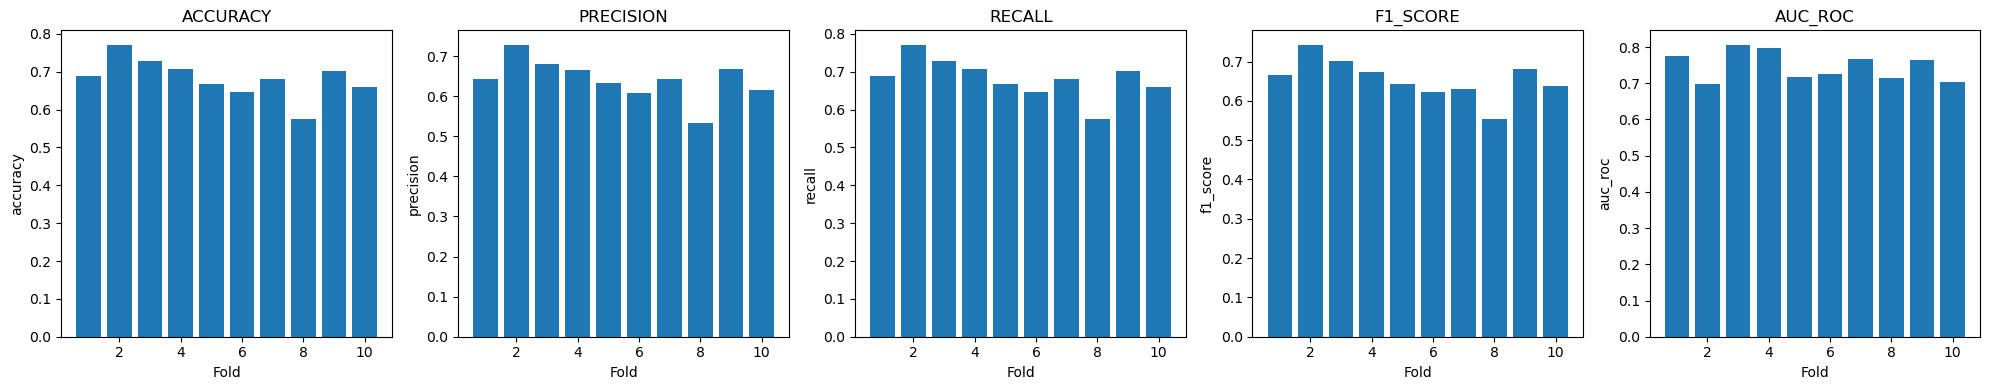

In [20]:

# %%
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))
metrics = ['accuracy','precision','recall','f1_score','auc_roc']
fig, axs = plt.subplots(1,len(metrics), figsize=(20,4))
for i,m in enumerate(metrics):
    axs[i].bar(cv_df['fold'], cv_df[m]); axs[i].set_title(m.upper()); axs[i].set_xlabel('Fold'); axs[i].set_ylabel(m)
plt.tight_layout(); plt.show()

# ## Step 7: Ensemble Averaging from 10 CV Models


In [21]:

# %%
ess_preds=[]
test_data=torch.load(os.path.join(base_path, f"{task}_test.pt"))
tl=DataLoader(test_data, batch_size=32)
for fold in range(10):
    model = MPNN(test_data[0].x.size(1), test_data[0].edge_attr.size(1), hidden_dim=best_hidden_dim, output_dim=num_classes, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval(); outs=[]
    with torch.no_grad():
        for b in tl: outs.append(model(b.to(device)).cpu())
    ess_preds.append(torch.cat(outs,0))
avg=torch.stack(ess_preds).mean(0)
f_pred=avg.argmax(1).numpy(); t_true=torch.cat([d.y for d in test_data]).numpy().astype(int)
pd.DataFrame({'True':t_true,'Pred':f_pred}).to_csv(os.path.join(results_dir,'ensemble_preds.csv'),index=False)
print('✅ Ensemble preds saved')

✅ Ensemble preds saved


# ## Step 7b: Ensemble Model Evaluation – Confusion Matrix & AUC‑ROC


✅ Ensemble metrics saved:
   accuracy  precision  recall  f1_score  balanced_accuracy  auc_roc
0    0.6981     0.6607  0.6981    0.6788             0.4866   0.8347


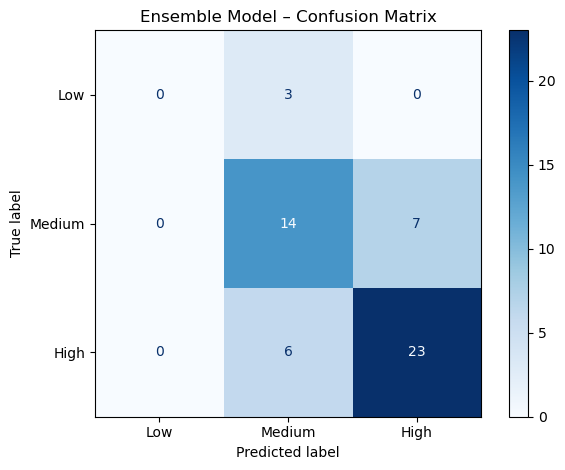

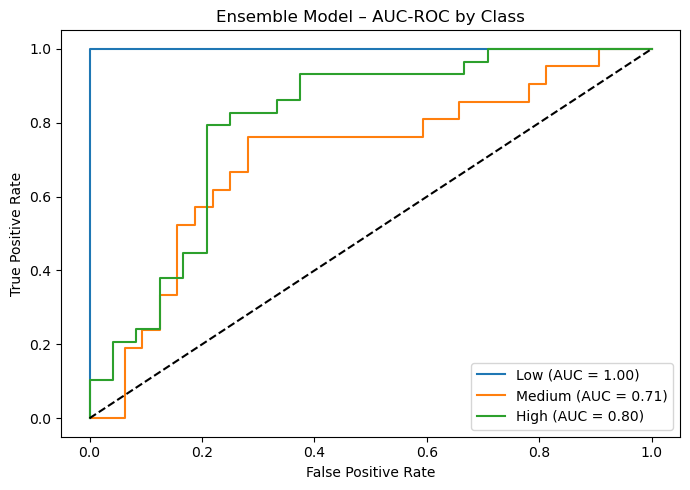

In [22]:

# %%
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# --- assume avg, f_pred, t_true are in scope from your ensemble cell ---
# avg: Tensor of shape [N_samples, num_classes] (averaged logits)
# f_pred: numpy array of hard predictions
# t_true: numpy array of true labels

# 1) Compute softmax probabilities
y_probs = F.softmax(avg, dim=1).numpy()

# 2) Compute classification metrics
accuracy  = accuracy_score(t_true, f_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    t_true, f_pred, average="weighted", zero_division=0
)
bal_acc   = balanced_accuracy_score(t_true, f_pred)

# For multiclass AUC-ROC we need one-hot true labels
y_true_bin = label_binarize(t_true, classes=np.arange(num_classes))
auc_ovr   = roc_auc_score(y_true_bin, y_probs, multi_class="ovr")

# 3) Save metrics to CSV
ensemble_metrics = pd.DataFrame([{
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "balanced_accuracy": bal_acc,
    "auc_roc": auc_ovr
}])
ensemble_metrics.to_csv(
    os.path.join(results_dir, "ensemble_model_metrics.csv"), index=False
)
print("✅ Ensemble metrics saved:")
print(ensemble_metrics.round(4))

# 4) (Optional) display confusion matrix and ROC curves here if you want
#    but metrics are now persisted for easy comparison to final_model_metrics.csv

# Load ensemble predictions
ens_df = pd.read_csv(os.path.join(results_dir, 'ensemble_preds.csv'))
y_true_ens = ens_df['True'].values
y_pred_ens = ens_df['Pred'].values

# Confusion matrix
cm = confusion_matrix(y_true_ens, y_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[class_names[i] for i in range(num_classes)])
disp.plot(cmap='Blues')
plt.title("Ensemble Model – Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC curves


plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble Model – AUC‑ROC by Class")
plt.legend()
plt.tight_layout()
plt.show()


# ## Step 8: Final Model Training on Combined Data & Test Evaluation


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | Train Loss: 0.8597 | Val Loss:   0.8353 | Best Val:   0.8353 | Patience:   0
Epoch 002 | Train Loss: 0.7758 | Val Loss:   0.7393 | Best Val:   0.7393 | Patience:   0
Epoch 003 | Train Loss: 0.7435 | Val Loss:   0.7210 | Best Val:   0.7210 | Patience:   0
Epoch 004 | Train Loss: 0.7343 | Val Loss:   0.7209 | Best Val:   0.7209 | Patience:   0
Epoch 005 | Train Loss: 0.7243 | Val Loss:   0.7037 | Best Val:   0.7037 | Patience:   0
Epoch 006 | Train Loss: 0.7236 | Val Loss:   0.7009 | Best Val:   0.7009 | Patience:   0
Epoch 007 | Train Loss: 0.7193 | Val Loss:   0.6954 | Best Val:   0.6954 | Patience:   0
Epoch 008 | Train Loss: 0.7079 | Val Loss:   0.6822 | Best Val:   0.6822 | Patience:   0
Epoch 009 | Train Loss: 0.7086 | Val Loss:   0.6885 | Best Val:   0.6822 | Patience:   1
Epoch 010 | Train Loss: 0.7073 | Val Loss:   0.6657 | Best Val:   0.6657 | Patience:   0
Epoch 011 | Train Loss: 0.6918 | Val Loss:   0.6540 | Best Val:   0.6540 | Patience:   0
Epoch 012 | Train Los

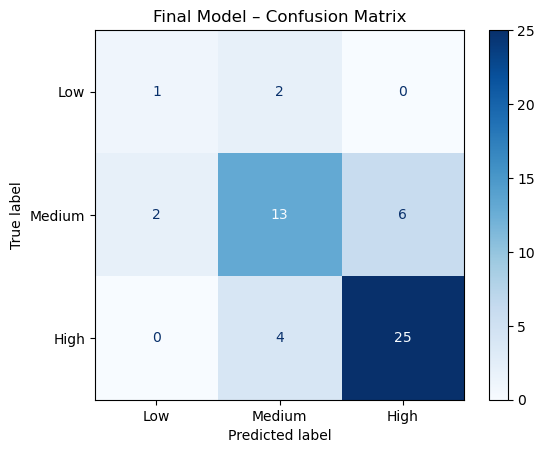

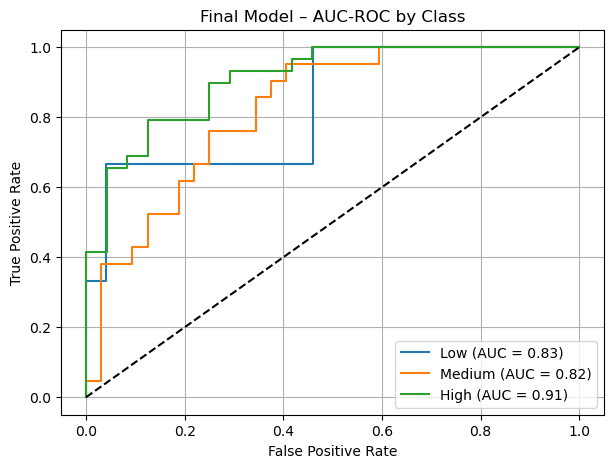

✅ Final confusion matrix saved
✅ Final AUC-ROC saved


In [ ]:
# %%
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

# 1) Merge train+val folds and reserve 10% for local validation
all_data = []
for fold in range(10):
    all_data += torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
labels = [int(d.y.item()) for d in all_data]
train_idx, val_idx = next(sss.split(all_data, labels))
train_split = [all_data[i] for i in train_idx]
val_split   = [all_data[i] for i in val_idx]

tr_loader = DataLoader(train_split, batch_size=32, shuffle=True,
                       worker_init_fn=seed_worker, generator=generator)
vl_loader = DataLoader(val_split,   batch_size=32)

# 2) Build model, optimizer, scheduler
model = MPNN(
    all_data[0].x.size(1),
    all_data[0].edge_attr.size(1),
    hidden_dim=best_hidden_dim,
    output_dim=num_classes,
    dropout=best_dropout
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

best_val_loss = float('inf')
patience = 0

# 3) Train with early stopping
for epoch in range(1, 301):
    model.train()
    train_loss = 0.0
    for b in tr_loader:
        b = b.to(device)
        optimizer.zero_grad()
        out = model(b)
        loss = F.cross_entropy(out, b.y.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(tr_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for b in vl_loader:
            b = b.to(device)
            out = model(b)
            val_loss += F.cross_entropy(out, b.y.long()).item()
    val_loss /= len(vl_loader)

    scheduler.step(val_loss)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), os.path.join(results_dir, 'final_model.pt'))
    else:
        patience += 1
        if patience >= 10:
            print("⏹️ Early stopping")
            break

    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss:   {val_loss:.4f} | "
          f"Best Val:   {best_val_loss:.4f} | "
          f"Patience:   {patience}")

# 4) Final Test Evaluation
model.load_state_dict(torch.load(os.path.join(results_dir, 'final_model.pt')))
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

preds, labels = evaluate(model, test_loader)
y_true = labels.numpy().astype(int)
y_pred = preds.argmax(dim=1).numpy()
y_probs = F.softmax(preds, dim=1).cpu().numpy()
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Metrics
acc      = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)
bal_acc  = balanced_accuracy_score(y_true, y_pred)
auc_ovr  = roc_auc_score(y_true_bin, y_probs, multi_class='ovr')

# Print final metrics
print("\n📊 Final Test Metrics:")
print(f"Accuracy           : {acc:.4f}")
print(f"Balanced Accuracy  : {bal_acc:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted)   : {recall:.4f}")
print(f"F1 Score (weighted) : {f1:.4f}")
print(f"AUC-ROC (ovr)       : {auc_ovr:.4f}")

# Save final metrics
final_metrics = {
    'accuracy': acc,
    'balanced_accuracy': bal_acc,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc_ovr
}
pd.DataFrame(final_metrics, index=[0]).to_csv(
    os.path.join(results_dir, 'final_model_metrics.csv'), index=False
)
print("✅ Final metrics saved")

# 5) Confusion Matrix & AUC-ROC plots
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(class_names.values()))
disp.plot(cmap='Blues')
plt.title('Final Model – Confusion Matrix')
plt.show()

plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title('Final Model – AUC-ROC by Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# Save confusion matrix
cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())
cm_df.to_csv(os.path.join(results_dir, 'final_confusion_matrix.csv'))
print("✅ Final confusion matrix saved")
# Save AUC-ROC
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_auc = auc(fpr, tpr)
roc_df.to_csv(os.path.join(results_dir, 'final_auc_roc.csv'), index=False)
print("✅ Final AUC-ROC saved")
    disp.ax_.set_ylabel('True pCHEMBL')
    disp.ax_.set_xlabel('Predicted pCHEMBL')
    plt.show()


## Step 9: compare ensemble averaging to final model training results

In [24]:
# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_model_metrics.csv'))
print("Columns in ensemble_df:", ensemble_df.columns)  # Debugging line to check column names
ensemble_acc=accuracy_score(t_true, y_pred_ens)  # Use t_true and y_pred_ens as they represent the true and predicted labels
final_metrics = {'ensemble': ensemble_acc, 'final': acc}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

Columns in ensemble_df: Index(['accuracy', 'precision', 'recall', 'f1_score', 'balanced_accuracy',
       'auc_roc'],
      dtype='object')


,Accuracy
ensemble,0.698113
final,0.735849
